<a id="chap0"></a>

## Setup

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display_png
from IPython.display import Image as ImageWidget
import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import glob
from pathlib import Path
from PIL import Image, ImageDraw

import ase
from ase import Atoms, units
from ase.units import Bohr,Rydberg,kJ,kB,fs,Hartree,mol,kcal
from ase.io import read, write
from ase.build import surface, molecule, add_adsorbate
from ase.constraints import FixAtoms, FixedPlane, FixBondLength, ExpCellFilter
from ase.neb import NEB
from ase.vibrations import Vibrations
from ase.thermochemistry import IdealGasThermo
from ase.visualize import view
from ase.build.rotate import minimize_rotation_and_translation
from ase.optimize import BFGS, LBFGS, FIRE
from ase.md import MDLogger
from ase.io import read, write, Trajectory
from ase.build import sort

from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode


estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL_PLUS_D3, model_version="v3.0.0")
calculator = ASECalculator(estimator)

### 2-4 List adsorption structures

In [2]:
from ase.io.vasp import read_vasp
ini = read_vasp('./inputs/initial/CONTCAR')
fin = read_vasp('./inputs/final/CONTCAR')

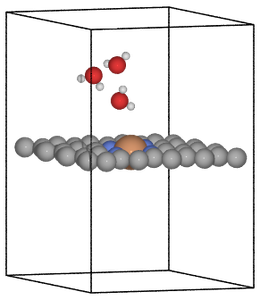

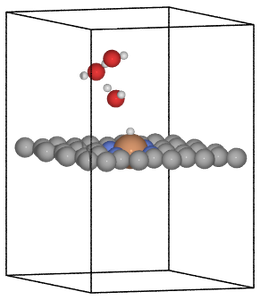

In [3]:
def render_and_display_np(structure, index, max_size=(300, 300)):
    renderer = write('{index}.pov', structure, rotation='10z,-80x')
    renderer.render()
    image_path = './{index}.png'
    img = Image.open(image_path)
    img.thumbnail(max_size, Image.LANCZOS)
    display(img)
render_and_display_np(ini,'ini',(300, 300))
render_and_display_np(fin,'fin', (300, 300))

In [4]:
from pfcc_extras.visualize.povray import traj_to_gif

traj_to_gif(
    [ini, fin],
    gif_filepath=f"./NEB_IS_FS.gif",
    pngdir=f"./hi.png",
    rotation="-60x, 30y, 15z",
    clean=False,
)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.3s finished


In [5]:
images = 11 

NEB is faster with `parallel = True` and `allowed_shared_calculator=False`.

In [13]:
IS= ini
FS=fin
b0 = IS.copy()
b1 = FS.copy()
configs = [b0.copy() for i in range(images-1)] + [b1.copy()]
for config in configs:
    # Calculator must be set separately with NEB parallel=True, allowed_shared_calculator=False.
    estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL_PLUS_D3, model_version="v2.0.0")
    calculator = ASECalculator(estimator)
    config.calc = calculator
configs2 = configs

First, linear interpolation of `configs`, which are candidate reaction pathways, is performed using NEB `interpolate` method.

In [14]:
# k： spring constant. It was stable to when reduced to 0.05
neb = NEB(configs, k=0.05, parallel=True, climb=True, allow_shared_calculator=False)  
neb_idpp = NEB(configs2, k=0.05, parallel=True, climb=True, allow_shared_calculator=False)  
neb.interpolate()
neb_idpp.interpolate(method='idpp') #https://wiki.fysik.dtu.dk/ase/tutorials/neb/idpp.html

Check reaction path candidate after linear interpolation

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  11 out of  11 | elapsed:    4.6s finished


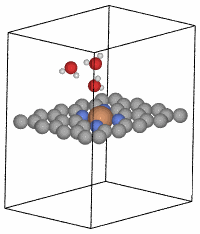

In [17]:
traj_to_gif(
    configs,
    gif_filepath=f"./NEB_interpolate.gif",
    rotation="-60x, 30y, 15z"
)
ImageWidget(f"./NEB_interpolate.gif")


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  11 out of  11 | elapsed:    4.7s finished


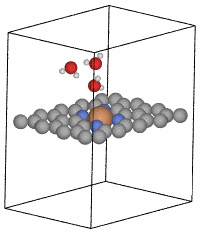

In [18]:
traj_to_gif(
    configs2,
    gif_filepath=f"./NEB_interpolate2.gif",
    rotation="-60x, 30y, 15z"
)
ImageWidget(f"./NEB_interpolate2.gif")

In [9]:
%%time
steps=2000

relax = FIRE(neb_idpp, trajectory=None, logfile="./neb_idpp_log.txt")
relax.run(fmax=0.1, steps=steps)
# fmax<0.05 recommended. It takes time when it is smaller.
# 1st NEB calculation can be executed with loose condition (Ex. fmax=0.2),
# and check whether reaction path is reasonable or not.
# If it is reasonable, run 2nd NEB with tight fmax condition.
# If the reaction path is abnormal, check IS, FS structure.


CPU times: user 1min 35s, sys: 15.9 s, total: 1min 51s
Wall time: 42min 27s


False

After the first loose convergence, check for anomalies in the reaction path.

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  11 out of  11 | elapsed:    4.9s finished


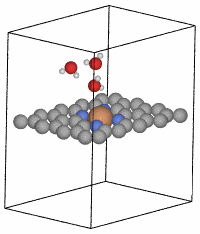

In [10]:
traj_to_gif(
    configs,
    gif_filepath=f"./NEB_result.gif",
    rotation="-60x, 30y, 15z"
)
ImageWidget(f"./NEB_result.gif")

After confirming that the reaction path is OK, a second NEB calculation is performed with tighter convergence conditions.

In [20]:
write("./NEB_images.xyz", configs)

<a id="chap4"></a>

## 4. Check NEB calculation results

First, let's visualize the results in several ways. Here, we will create a gif file from png figures.

Obtain the index of TS structure. <br/>
Looking at the energy and force, you can see that the system reaches the [saddle point](https://en.wikipedia.org/wiki/Saddle_point) (see below) at index=12 where the energy is maximum and the force is near 0.

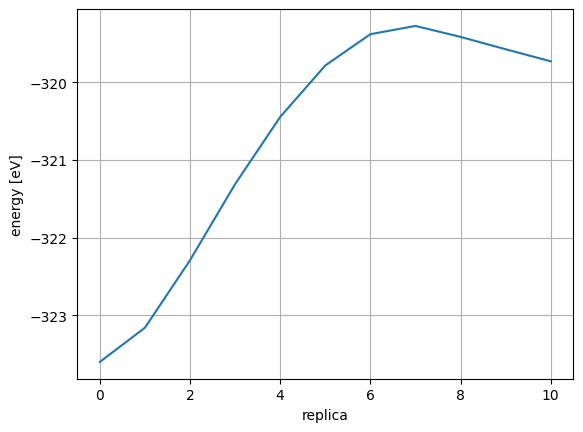

In [23]:
for config in configs2:
    config.calc = calculator
energies = [config.get_total_energy() for config in configs]

plt.plot(range(len(energies)),energies)
plt.xlabel("replica")
plt.ylabel("energy [eV]")
plt.xticks(np.arange(0, len(energies), 2))
plt.grid(True)
plt.show()

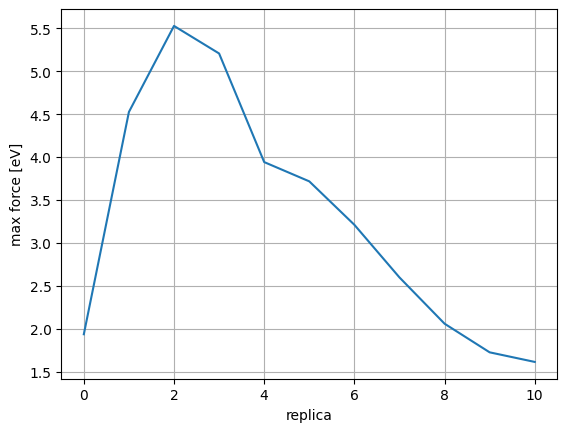

In [24]:
def calc_max_force(atoms):
    return ((atoms.get_forces() ** 2).sum(axis=1).max()) ** 0.5

mforces = [calc_max_force(config) for config in configs]
plt.plot(range(len(mforces)), mforces)
plt.xlabel("replica")
plt.ylabel("max force [eV]")
plt.xticks(np.arange(0, len(mforces), 2))
plt.grid(True)
plt.show()

In [26]:
ts_index = 5
actE = energies[ts_index] - energies[0]
deltaE = energies[ts_index] - energies[-1]
print(f"actE {actE} eV, deltaE {deltaE} eV")

actE 3.818601258502156 eV, deltaE -0.053631331908263746 eV
